In [2]:
!pip install -U FlagEmbedding

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 15.9 kB/s eta 0:00:00a 0:00:02
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/9.5 MB 13.8 kB/s eta 0:07:39
ERROR: Exception:
Traceback (most recent call last):
  File "/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/pip/_vendor/cachecontro

In [ ]:
'''
用于在RAG中对文本进行分片的函数，不包含embedding
'''

import re
import numpy as np


def split_text_to_sentences(text,split_chars=".?!。\n！："):
    ''' 按分割符切割文本成句子'''
    pattern = re.compile(f'(?<=[{split_chars}])\s+')
    single_sentences_list = pattern.split(text)

    # 去除列表中的空字符串项，并记录每个句子在原文中的起始和结束位置
    start_idx = 0

    sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]

    for item in sentences:
        item["length"] = len(item['sentence'])
        item['start_idx'] = start_idx
        start_idx += item["length"]
        # 跳过分隔符长度
        while start_idx < len(text) and text[start_idx] in split_chars:
            start_idx += 1
    
    return sentences
    

def combine_sentences(sentences, buffer_size=1):
    '''
    把[i-buffer_size,i]范围内的句子对象合并，返回一个纯句子列表
    Args:
        sentences:      句子对象构成的列表
        buffer_size:    缓冲区长度
    Returns:
        combined_sentences(list)
    '''
    combined_sentences = [
        ' '.join(sentences[j]['sentence'] for j in range(max(i - buffer_size, 0), min(i + 1, len(sentences))))
        for i in range(len(sentences))
    ]   

    return combined_sentences

def cosine_similarity(vec1, vec2):
    """计算两个向量的余弦相似度"""
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def calculate_cosine_distances(vec1_list, vec2_list):
    """
    计算两组向量之间的余弦距离。
    
    Args:
        vec1_list (list of arrays): 第一组向量的列表。
        vec2_list (list of arrays): 第二组向量的列表，与第一组向量对应。

    Returns:
        distances (list): 每对向量之间的余弦距离的列表。
    """
    assert len(vec1_list) == len(vec2_list), "向量列表长度不一致"
    distances = []
    n = len(vec1_list)
    for i in range(n):
        # 计算余弦相似度
        similarity = cosine_similarity(vec1_list[i], vec2_list[i])
        # 转换为余弦距离
        distance = 1 - similarity
        distances.append(distance)
    return distances


def build_chunks(text, sentences,distances,breakpoint_percentile_threshold=95,max_len=450):
    '''
    根据距离把文本分片
    Input:
        text:       原文
        sentences:  句子列表
        distances:  跟下句的相似距离
        breakpoint_percentile_threshold：   距离分割阈值分位数（0-100）
        max_len:    最大片段长度
    '''
    if len(sentences)<=1: # 全文被分为一句话
        return [{"start_idx":sentences[0]["start_idx"], "text": text}]

    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] + [len(sentences)-1] + ["end"]

    chunks = []
    start_sent_idx = 0
    pin = 0
    last_sent_idx = indices_above_thresh[pin]
    while last_sent_idx!="end":
        combined_text = text[sentences[start_sent_idx]["start_idx"]: sentences[last_sent_idx]["start_idx"]+sentences[last_sent_idx]["length"]]
        # print(len(combined_text))
        if len(combined_text) < max_len or last_sent_idx==start_sent_idx:
            chunk = {"text":combined_text,"sentence_range":[start_sent_idx,last_sent_idx]}
            chunks.append(chunk)
            # 更新循环变量 
            start_sent_idx = last_sent_idx + 1
            pin += indices_above_thresh[pin]==last_sent_idx  # 如果当前分裂原因不是max_len，就+1
            last_sent_idx = indices_above_thresh[pin]
        else:
            last_sent_idx = start_sent_idx + np.argmax(distances[start_sent_idx:last_sent_idx])  # 不含last_sent_idx

    return chunks


def find_emb_matched_chunks_ids(query_embeddings, chunk_embeddings, topn=10, min_similarity=0.51,relaxation_limit=2):
    """
    寻找匹配片段

    Args:
        query_embeddings (list): 查询片段的嵌入列表
        chunk_embeddings (list): 上下文片段的嵌入列表
        topn (int, optional): 返回每个查询片段的最大匹配数
        min_similarity (float, optional): 最小的余弦相似度阈值，用于确定匹配
        relaxation_limit (int, optional): 如果没有匹配的片段时的松弛限制数量

    Returns:
        list: 匹配片段的索引列表，每个查询片段对应一个子列表    (n,*)二维列表，n为查询数
    """
    matched_indices = []

    for query_embedding in query_embeddings:
        temp = []

        # 计算查询片段与所有上下文片段的余弦相似度
        similarities = [cosine_similarity(query_embedding, chunk_embedding) for chunk_embedding in chunk_embeddings]

        # 对相似度数组进行排序并获取排序后的索引
        sorted_indices = np.argsort(similarities)[::-1]

        # 选择符合最小相似度阈值且未超过匹配数的索引
        for idx in sorted_indices:
            if similarities[idx] > min_similarity :
                temp.append(idx)
        
        # 如果召回为0则根据relaxation_limit设定松弛
        if len(temp)==0:
            temp += sorted_indices[:relaxation_limit]

        matched_indices.append(temp[:topn])

    return matched_indices

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
model2 = AutoModel.from_pretrained('../models/bge-large-zh-v1.5')
model2.eval()
model2

/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
import re
import numpy as np
import sys
sys.path.append("..")

In [2]:
from FlagEmbedding import FlagModel
model = FlagModel('../base/bge_small', query_instruction_for_retrieval="为这个句子生成表示以用于检索相关文章：")

/home/newdisk/jxh/anaconda/envs/sft2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----------using 4*GPUs----------


In [3]:
# 示例文本
text = "青藏高原之后，紧接着是云贵高原、内蒙古高原以及西北内陆地区太阳辐射量较高；而华东、华南地区辐照度较低，最低者便是文章开头提到的四川盆地。\n\n\n\n下面是按照民族和地区对人群肤色进行的分析：普遍规律是：\n\n生活在辐射高地区的人群肤色深\n\n生活在辐射低地区的人群肤色浅\n\n\n\n如果吸收太多紫外线辐射，会让皮肤皱纹增加，变得粗糙、松垂、缺乏弹性。过强紫外线照射还会导致皮肤不均匀地增厚和变薄，常见的阳光引起的皮肤色素变化是雀斑和晒斑，这两者都是长时间暴露在日光下导致的。\n\n\n\n像是海南三亚的太阳紫外线辐射是沈阳的两倍，但三亚男性皮肤老化的风险是沈阳男性的约6倍，女性则达到了惊人的11倍。\n\n\n\n\n\n\n\n\n\n当然了地理君温馨提醒：\n\n以上说的都是普遍性，假如你生活在四川盆地皮肤却很黑，那只能说明你：没做好防晒！\n\n\n气候湿润地区的高颜值“密码”\n\n\n\n除了皮肤颜色外，令人羡慕的优质皮肤还需满足两个条件：一是皮肤的含水量要足够多；二是皮肤出油率要保持较低水平。\n\n\n\n皮肤的含水量跟湿度密切相关，湿度过低，人体皮肤因缺少水分而变得粗糙甚至开裂，人体的免疫系统也会受到伤害，对疾病的抵抗力大大降低甚至丧失；\n\n\n\n而湿度过高时，并且如果长久呆在潮湿空气中，人体皮肤会出现少量细菌感染或者皮肤发痒等现象。所以长时间呆在湿度过高或者过低的环境里都是不利于皮肤的发育。\n\n\n\n\n通常情况下，人体皮肤所需的舒适气温在10~22℃之间，这相当于皮肤所需的舒适湿度在25%~45%之间。\n\n\n\n1月是冬季的典型代表，皮肤最喜欢的相对湿度45%等值线大体沿25°N分布，也就是南岭以南的华南地区。\n\n\n\n\n5月是春季的代表，此时也是全国湿度的舒适范围达到最大的月份，除了东北北部和青藏高原腹地外，全国都在舒适带范围内。\n\n\n\n7月是夏季的代表，“热”字当头，除了东北北部和青藏高原外，全国其它地区都不在舒适带范围内。\n\n\n\n\n以9月、10月为主的秋季，全国舒适带的范围和春季的分布相差无几。\n\n\n\n那么哪个地区相对而言湿度要更大一些呢？\n\n\n\n答案是：川渝地区仍然榜上有名。\n\n\n\n总体上，根据2021年《中国统计年鉴》的数据，西南地区的平均相对湿度更舒适一些，这样的湿度更利于形成或维持水润的皮肤。\n\n\n\n\n\n\n\n\n\n地理君再次温馨提醒：\n\n皮肤适宜的舒适湿度同样具有普遍性，假如你生活在川渝地区皮肤却很干或者皱纹很多，那说明你：有可能是吸烟人群。\n\n图片\n\n\n\n\n\n\n除此以外，由于地域辽阔，自然环境特征复杂多样，普遍性中往往有很多的个例。\n\n\n\n例如，长春的冬季漫长、寒冷干燥，气候条件比很多南方城市还要恶劣，但正是因为冬季严寒，当地人们反而在户外活动的时间变少，防寒保暖的措施更加牢固，因此长春人皮肤的水分状况反而要比江苏、湖南等地的人们的皮肤好。\n\n\n\n吸烟有害健康大家都知道，但是吸烟对皮肤的伤害也很大，甚至超过了阳光带给皮肤的伤害。\n\n\n\n吸烟会导致皮肤的新陈代谢功能降低，易于发生皮肤老化。还会降低人体胶原合成的减少，易于皮肤产生皱纹。\n\n\n\n\n当今社会，中国的平均吸烟率在25%左右，但是男女吸烟率差距极大，男性吸烟率接近50%，女性吸烟率仅3.1%左右。但是15岁以上人群中吸烟者在2018年便超过了总吸烟人数的四分之一。\n\n\n\n一篇发表在《柳叶刀》的文章研究称：我国最喜欢吸烟的人群主要分布在西北地区，比如宁夏银川人吸烟率就高达49.8%。\n\n\n\n而南方一些省市的吸烟率，例如贵州省超过了40%，江浙沪、云南四川等地对烟草的依赖则最低，总体上是北方多于南方。\n\n\n\n\n除了吸烟会影响皮肤状况外，皮肤出油率高、经常爆痘也是其重要影响因素。\n\n\n\n时不时长个痘，难受不？该不该挤呢？\n\n\n\n实话实说，痘痘的发病率是有明显的地域差别。跟人们普遍认知不同的是，南方的爆痘率要明显高于北方。\n\n\n\n华南地区更是长痘的重灾区。这是因为湿度过高、气温炎热的广州、三亚等地，人们的皮脂分泌通常也较旺盛，皮肤相对油腻、容易爆痘。\n\n\n\n那么，全国最不长痘的地方在哪里呢？\n\n\n\n依旧是川渝所在的西南地区，不愧“天府之国”啊！\n\n\n\n不止在爆痘率上，出油率南方也是高于北方地区。北方气候比较冷，空气干燥。皮肤毛孔收缩，保持皮肤的含水量，皮脂腺分泌降低，皮肤内的水分也用来保持皮肤湿润，因此皮肤油脂少。\n\n\n\n而南方空气相较于北方要暖和且空气湿润，因此皮肤新陈代谢快，皮脂腺分泌旺盛，就导致了皮肤容易出油。\n\n\n\n其实出油并不代表皮肤水分充足，恰恰相反，正是由于人体皮肤干燥缺水，导致肌肤受损，人体自我修复和保护系统才会分泌油脂来保护肌肤！所以即使在南方也要做到皮肤及时补水。\n\n\n\n一个地区的人的皮肤状况和自然地理环境有一定联系，而且这种联系也是潜移默化的，但是随着人口流动的增加，导致基因多元化，所以二者联系越来越小"


sentences = split_text_to_sentences(text)

# 打印结果
for item in sentences[:2]:
    idx, sentence, start = item["index"],item['sentence'],item["start_idx"]
    print(f"Sentence {idx+1}")
    print(sentence)
    print("------")
    #print(f"Start Index: {start}")
    print(text[start:start+len(sentence)],"\n")


Sentence 1
青藏高原之后，紧接着是云贵高原、内蒙古高原以及西北内陆地区太阳辐射量较高；而华东、华南地区辐照度较低，最低者便是文章开头提到的四川盆地。
------
青藏高原之后，紧接着是云贵高原、内蒙古高原以及西北内陆地区太阳辐射量较高；而华东、华南地区辐照度较低，最低者便是文章开头提到的四川盆地。 

Sentence 2
下面是按照民族和地区对人群肤色进行的分析：普遍规律是：
------
下面是按照民族和地区对人群肤色进行的分析：普遍规律是： 



In [4]:
combined_sentences_pre1 = combine_sentences(sentences,buffer_size=1)
combined_sentences_pre2 = combine_sentences(sentences,buffer_size=2)

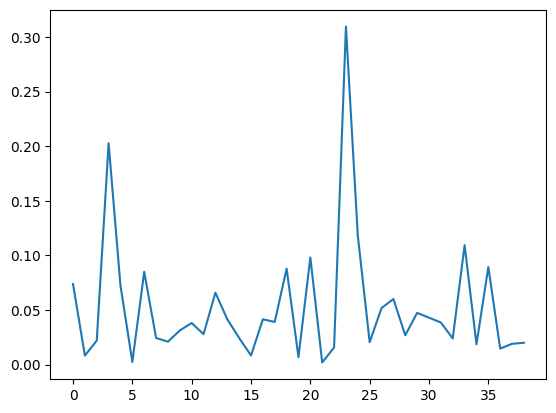

In [5]:
import matplotlib.pyplot as plt
combined_sentence_pre1_embeddings = model.encode(combined_sentences_pre1)
combined_sentence_pre2_embeddings = model.encode(combined_sentences_pre2)
distances = calculate_cosine_distances(combined_sentence_pre1_embeddings[:-1],combined_sentence_pre2_embeddings[1:])
plt.plot(distances)

In [43]:
chunks_lib = {"large":build_chunks(text,sentences,distances,75),"small":build_chunks(text,sentences,distances,30)}
# 定义一个小到大映射
fa = [0] * len(chunks_lib["small"])
for i, chunk in enumerate(chunks_lib["small"]):
    fa[i] = fa[i-1] if i>0 else 0 # 初始化，因为两个chunks都是按句子切的必然有序
    small_range = sentence_range = chunk["sentence_range"]
    large_range = chunks_lib["large"][fa[i]]["sentence_range"]
    while not (small_range[1]<=large_range[1] and small_range[0]>=large_range[0]) :
        fa[i] += 1
        large_range = chunks_lib["large"][fa[i]]["sentence_range"]

print(fa)

for i, chunk in enumerate(chunks_lib["small"][:3]):
    print (f"Chunk #{i}")
    print (chunk["text"].replace("\n\n"," ").strip())
    print ("\n")

[0, 1, 1, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 7, 8, 9, 9, 10, 10, 10, 10, 10, 10, 11, 12]
Chunk #0
青藏高原之后，紧接着是云贵高原、内蒙古高原以及西北内陆地区太阳辐射量较高；而华东、华南地区辐照度较低，最低者便是文章开头提到的四川盆地。


Chunk #1
下面是按照民族和地区对人群肤色进行的分析：普遍规律是： 生活在辐射高地区的人群肤色深


Chunk #2
生活在辐射低地区的人群肤色浅




In [50]:
queries = ["什么地区的人皮肤容易长痘？","吸烟对身体健康的危害","肤色与地区的关系"]
q_embeddings = model.encode_queries(queries)
c_embeddings = {chunksize:model.encode([x["text"] for x in chunks]) for chunksize,chunks in chunks_lib.items()}

In [52]:
# 从小片段中检索
matched_samll_chunks_ids = find_emb_matched_chunks_ids(q_embeddings, c_embeddings["small"])  
# 后处理
min_gain = 0.05 # 取父chunk的最小提升条件
for q_i, q_embedding in enumerate(q_embeddings):
    print("\nQuestion:",queries[q_i])
    return_ids = {"large":set(),"small":[]}
    for c_i in matched_samll_chunks_ids[q_i]:
        score = cosine_similarity(q_embedding, c_embeddings["small"][c_i])
        fa_score = cosine_similarity(q_embedding, c_embeddings["large"][fa[c_i]])
        if fa_score > score+min_gain:
            return_ids["large"].add(fa[c_i])
    return_ids["small"] = [c_i for c_i in matched_samll_chunks_ids[q_i] if fa[c_i] not in return_ids["large"]]
    print(matched_samll_chunks_ids[q_i])
    print(return_ids)

    ans = []
    for chunk_size,ids in return_ids.items():
        for id in ids:
            start_sent_id, last_sent_id = chunks_lib[chunk_size][id]["sentence_range"]
            start_idx, end_idx = sentences[start_sent_id]["start_idx"], sentences[last_sent_id]["start_idx"]+sentences[last_sent_id]["length"]
            print(text[start_idx:end_idx].replace("\n\n","").strip())
            print("----")


Question: 什么地区的人皮肤容易长痘？
[25, 17, 24, 27, 26]
{'large': set(), 'small': [25, 17, 24, 27, 26]}
华南地区更是长痘的重灾区。这是因为湿度过高、气温炎热的广州、三亚等地，人们的皮脂分泌通常也较旺盛，皮肤相对油腻、容易爆痘。
----
例如，长春的冬季漫长、寒冷干燥，气候条件比很多南方城市还要恶劣，但正是因为冬季严寒，当地人们反而在户外活动的时间变少，防寒保暖的措施更加牢固，因此长春人皮肤的水分状况反而要比江苏、湖南等地的人们的皮肤好。
----
实话实说，痘痘的发病率是有明显的地域差别。跟人们普遍认知不同的是，南方的爆痘率要明显高于北方。
----
不止在爆痘率上，出油率南方也是高于北方地区。北方气候比较冷，空气干燥。皮肤毛孔收缩，保持皮肤的含水量，皮脂腺分泌降低，皮肤内的水分也用来保持皮肤湿润，因此皮肤油脂少。而南方空气相较于北方要暖和且空气湿润，因此皮肤新陈代谢快，皮脂腺分泌旺盛，就导致了皮肤容易出油。其实出油并不代表皮肤水分充足，恰恰相反，正是由于人体皮肤干燥缺水，导致肌肤受损，人体自我修复和保护系统才会分泌油脂来保护肌肤！所以即使在南方也要做到皮肤及时补水。一个地区的人的皮肤状况和自然地理环境有一定联系，而且这种联系也是潜移默化的，但是随着人口流动的增加，导致基因多元化，所以二者联系越来越小
----
那么，全国最不长痘的地方在哪里呢？依旧是川渝所在的西南地区，不愧“天府之国”啊！
----

Question: 吸烟对身体健康的危害
[18, 22, 19]
{'large': {9}, 'small': [22]}
吸烟有害健康大家都知道，但是吸烟对皮肤的伤害也很大，甚至超过了阳光带给皮肤的伤害。吸烟会导致皮肤的新陈代谢功能降低，易于发生皮肤老化。还会降低人体胶原合成的减少，易于皮肤产生皱纹。
当今社会，中国的平均吸烟率在25%左右，但是男女吸烟率差距极大，男性吸烟率接近50%，女性吸烟率仅3.1%左右。但是15岁以上人群中吸烟者在2018年便超过了总吸烟人数的四分之一。
----
除了吸烟会影响皮肤状况外，皮肤出油率高、经常爆痘也是其重要影响因素。
----

Question: 肤色与地区的关系
[1, 2, 17, 6]
{'large': {1}, 'smal